# Model Selection, Underfitting, and Overfitting

- Training Error
- Generalization Error
- $K$ Fold Cross-Validation

![capacity-vs-error](./images/capacity-vs-error.svg)

- VC dimension


In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

$$
y=5+1.2 x-3.4 \frac{x^{2}}{2 !}+5.6 \frac{x^{3}}{3 !}+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.1^{2}\right)
$$

In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.7954],
         [-0.3200]]),
 tensor([[ 1.0000e+00, -7.9539e-01,  3.1632e-01, -8.3865e-02,  1.6676e-02,
          -2.6528e-03,  3.5167e-04, -3.9959e-05,  3.9728e-06, -3.5111e-07,
           2.7926e-08, -2.0193e-09,  1.3384e-10, -8.1890e-12,  4.6524e-13,
          -2.4670e-14,  1.2264e-15, -5.7379e-17,  2.5355e-18, -1.0614e-19],
         [ 1.0000e+00, -3.2005e-01,  5.1215e-02, -5.4638e-03,  4.3716e-04,
          -2.7983e-05,  1.4926e-06, -6.8245e-08,  2.7302e-09, -9.7088e-11,
           3.1073e-12, -9.0406e-14,  2.4112e-15, -5.9361e-17,  1.3570e-18,
          -2.8954e-20,  5.7917e-22, -1.0904e-23,  1.9387e-25, -3.2657e-27]]),
 tensor([2.4708, 4.3634]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### Normal

weight: [[ 5.0046425  1.2355359 -3.3658545  5.534615 ]]


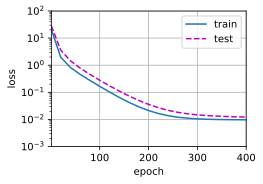

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### Underfitting

weight: [[3.5135446 3.0713558]]


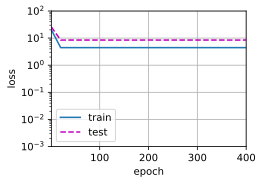

In [8]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### Overfitting

weight: [[ 5.0000687   1.2732177  -3.3026183   5.269199   -0.29143015  1.0637475
   0.10500127  0.21339251 -0.05943387  0.03194846  0.01201408 -0.05187401
   0.11064379 -0.21243717  0.17175254  0.05847191  0.14912257 -0.14284797
   0.10308167  0.14903253]]


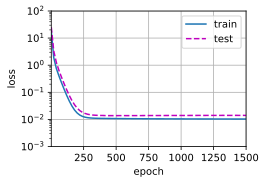

In [9]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)